### Predicting day-ahead energy consumption using ANN: 
Traditional methods for time series forecasting like ARIMA has its limitation as it can only be used for univariate data and one step forecasting. VAR(vector autoregression) model can do multivariate regression, or, it is observed in various studies that deep learning models like ANN(MLP) or RNN(LSTM) outperform traditional forecasting methods on multivariate time series data.

In [1]:
from datetime import datetime as dt, timedelta
import pandas as pd
import numpy as np
import loadForecast as lf
import mpld3
mpld3.enable_notebook()
%matplotlib inline

In [2]:
f = 'data/NORTH.csv'
df = pd.read_csv(f)
all_X = lf.makeUsefulDf(df).to_numpy()
all_y = df['load'].to_numpy()
# convert boolean features into float32 variables
all_X = np.asarray(all_X).astype(np.float32)
# print(all_X.shape, all_y.shape)
# print(all_X, all_y)

In [3]:
predictions, accuracy = lf.hour_ahead_predictions(all_X, all_y)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Epoch 1/10


2022-02-11 13:55:44.582400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-11 13:55:44.582536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-11 13:55:44.677013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 13:55:44.679264: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



   1/4380 [..............................] - ETA: 22:19 - loss: 1119032.7500 - mean_absolute_error: 1019.3207 - mean_squared_error: 1119032.7500

2022-02-11 13:55:44.846150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4380/4380 [==============================] - 33s 7ms/step - loss: 119212.5312 - mean_absolute_error: 187.8808 - mean_squared_error: 119212.5312
Epoch 2/10
4380/4380 [==============================] - 32s 7ms/step - loss: 5445.9824 - mean_absolute_error: 51.9088 - mean_squared_error: 5445.9824
Epoch 3/10
4380/4380 [==============================] - 32s 7ms/step - loss: 4787.2974 - mean_absolute_error: 48.1946 - mean_squared_error: 4787.2974
Epoch 4/10
4380/4380 [==============================] - 33s 7ms/step - loss: 4504.0635 - mean_absolute_error: 46.4912 - mean_squared_error: 4504.0635
Epoch 5/10
4380/4380 [==============================] - 32s 7ms/step - loss: 4319.9531 - mean_absolute_error: 45.3654 - mean_squared_error: 4319.9531
Epoch 6/10
4380/4380 [==============================] - 33s 7ms/step - loss: 4194.1709 - mean_absolute_error: 44.4691 - mean_squared_error: 4194.1709
Epoch 7/10
4380/4380 [==============================] - 33s 7ms/step - loss: 4086.8359 - mean_absolute_err

2022-02-11 14:01:09.945148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-11 14:01:10.343104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Percent accuracy (MAPE). Train: 95.75457712991701.  Test: 95.93465666422036


<AxesSubplot:title={'center':'NORTH Texas 2018: prediction v. actual load'}>

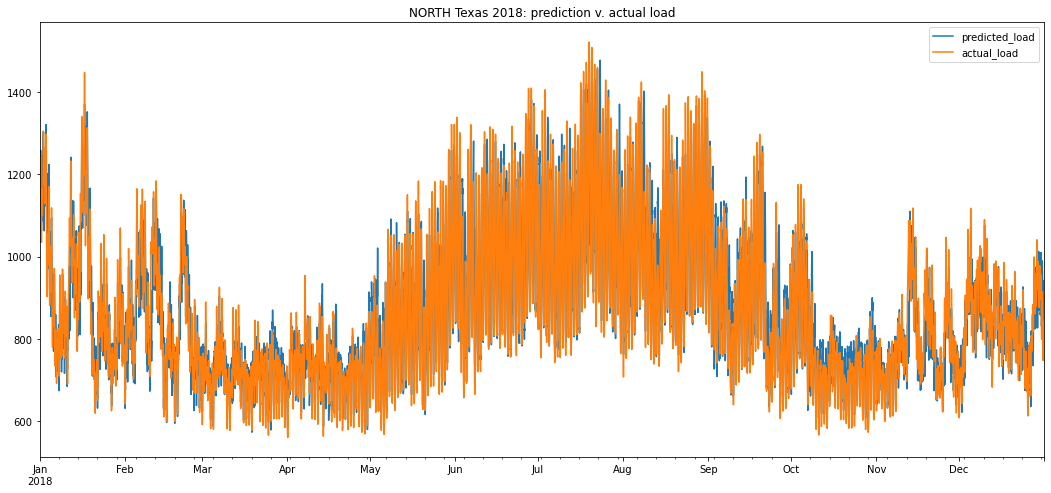

In [4]:
print('Percent accuracy (MAPE). Train: {}.  Test: {}'.format(100-accuracy['train'], 100-accuracy['test']))

df_r = pd.DataFrame()
df_r['predicted_load'] = predictions
df_r['actual_load'] = [float(f) for f in all_y[-8760:]]
df_r.index = [dt(2018, 1, 1, 0) + timedelta(hours=1)*i for i in range(8760)]
df_r.plot(figsize=(18, 8), title="{} Texas 2018: prediction v. actual load".format(f[5:10]))

The new structure effectively combines 24 hourly models. But instead of calculating a single hour, we combine all weights into one flat, fully-connected dense layer (half of window * features number of nodes). That layer is then fully connected to a 24-hour vector for one day ahead forecast. 

In [3]:
window = 24
all_y_rnn = lf.data_transform(all_y, window, var='y')
all_X_rnn = lf.data_transform(all_X, window, var='x')
#print(all_X_rnn.shape, all_y_rnn.shape)
#print(all_X_rnn, all_y_rnn)

In [4]:
predictions, accuracy = lf.day_ahead_predictions(all_X_rnn, all_y_rnn, window)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2022-02-11 15:56:41.012255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-11 15:56:41.012407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-11 15:56:41.437100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 15:56:41.439314: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-02-11 15:56:41.752385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4380/4380 [==============================] - 137s 31ms/step - loss: 6.2026 - mae: 60.5575 - mape: 6.2026
Epoch 2/10
4380/4380 [==============================] - 137s 31ms/step - loss: 3.0860 - mae: 30.2961 - mape: 3.0860
Epoch 3/10
4380/4380 [==============================] - 137s 31ms/step - loss: 2.4752 - mae: 24.3547 - mape: 2.4752
Epoch 4/10
4380/4380 [==============================] - 137s 31ms/step - loss: 2.1644 - mae: 21.3286 - mape: 2.1644
Epoch 5/10
4380/4380 [==============================] - 138s 31ms/step - loss: 1.9953 - mae: 19.6546 - mape: 1.9953
Epoch 6/10
4380/4380 [==============================] - 137s 31ms/step - loss: 1.8852 - mae: 18.5906 - mape: 1.8852
Epoch 7/10
4380/4380 [==============================] - 137s 31ms/step - loss: 1.8053 - mae: 17.8151 - mape: 1.8053
Epoch 8/10
4380/4380 [==============================] - 139s 32ms/step - loss: 1.7446 - mae: 17.2120 - mape: 1.7446
Epoch 9/10
4380/4380 [==============================] - 137s 31ms/step - loss: 1.68

2022-02-11 16:19:35.353832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [5]:
print('Percent accuracy (MAPE). Train: {}.  Test: {}'.format(100-accuracy['train'], 100-accuracy['test']))

Percent accuracy (MAPE). Train: 98.33285554430996.  Test: 98.07344233510953
